In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import sys
import json
import wave
import time
import pyaudio
import librosa
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Audio
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalMaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, f1_score, recall_score
from sklearn.model_selection import train_test_split


In [2]:
SEED = 42
BATCH_SIZE = 32
SAMPLE_RATE = 16000
VALIDATION_SPLIT = 0.2

In [3]:
def load_data(json_path):
    with open(json_path, "r") as fp:
        data = json.load(fp)
    return data

train_data = load_data('train_mfccs.json')
test_data = load_data('test_mfccs.json')


In [4]:
# Convert lists to numpy arrays
X_train = np.array(train_data["mfcc"])
y_train = np.array(train_data["labels"])
X_test = np.array(test_data["mfcc"])
y_test = np.array(test_data["labels"])

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [5]:

# Model definition
def build_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

    model.add(GlobalMaxPooling2D())  # Add GlobalMaxPooling2D layer

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(len(np.unique(y_train)), activation='softmax'))

    return model

# Input shape
input_shape = (X_train.shape[1], X_train.shape[2], 1)

# Build model
model = build_model(input_shape)

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=50)


/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3852 - loss: 1.5646 - val_accuracy: 0.5043 - val_loss: 1.2305
Epoch 2/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4855 - loss: 1.2460 - val_accuracy: 0.5332 - val_loss: 1.1597
Epoch 3/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5179 - loss: 1.1891 - val_accuracy: 0.5693 - val_loss: 1.1187
Epoch 4/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5474 - loss: 1.1380 - val_accuracy: 0.5664 - val_loss: 1.1134
Epoch 5/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5658 - loss: 1.1078 - val_accuracy: 0.6143 - val_loss: 1.0027
Epoch 6/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5958 - loss: 1.0462 - val_accuracy: 0.6154 - val_loss: 1.0477
Epoch 7/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6118 - loss: 1.0220 - val_accuracy: 0.6209 - val_loss: 0.9916
Epoch 8/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6135 - loss: 1.0211 - val_accuracy: 0.

In [6]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.2f}')

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5567 - loss: 1.2933
Test Accuracy: 0.54


In [7]:
# Assuming you have the test data prepared as X_test and y_test
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Calculate accuracy, precision, and F1 score
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Print classification report
class_report = classification_report(y_test, y_pred_classes)
print("Classification Report:\n", class_report)



164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.48      0.49       983
           1       0.51      0.93      0.66       608
           2       0.73      0.52      0.61       961
           3       0.66      0.48      0.55       942
           4       0.45      0.50      0.47       857
           5       0.47      0.45      0.46       885

    accuracy                           0.54      5236
   macro avg       0.55      0.56      0.54      5236
weighted avg       0.56      0.54      0.53      5236



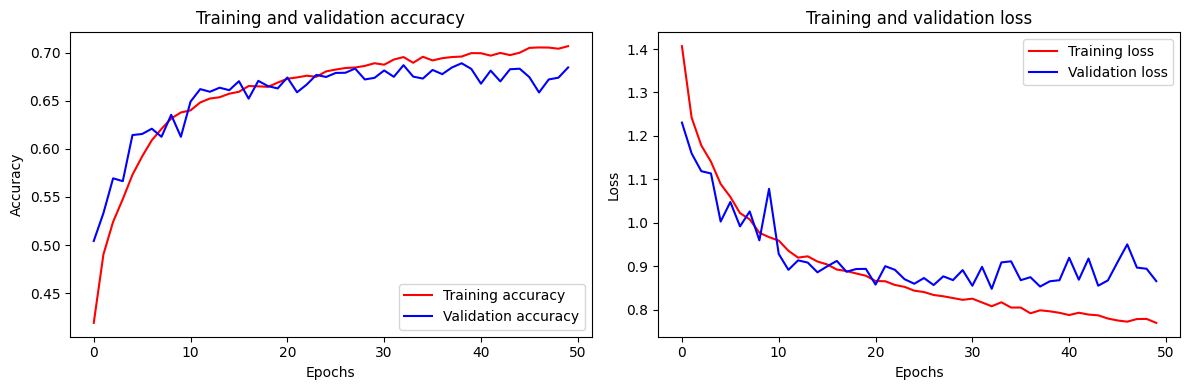

In [8]:

# Function to plot the training history
def plot_training_history(history):
    try:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(len(acc))

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, 'r', label='Training accuracy')
        plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'r', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"An error occurred during plotting the training history: {str(e)}")
        
plot_training_history(history)


In [9]:
model.save("audio_classification_model.h5")

In [10]:
def predict(file_path, model):
    # Load the audio file
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T

    # Ensure the correct shape
    mfcc = np.expand_dims(mfcc, axis=-1)
    mfcc = np.expand_dims(mfcc, axis=0)

    # Make prediction
    prediction = model.predict(mfcc)
    predicted_index = np.argmax(prediction, axis=1)
    return predicted_index

# Load the model
model = tf.keras.models.load_model('audio_classification_model.h5')



In [11]:
train_data_dir = pathlib.Path('Dataset/Train')

emabega_file_path = os.path.join(train_data_dir, 'emabega', 'emabega_001.wav')
ddyo_file_path = os.path.join(train_data_dir, 'ddyo', 'ddyo_001.wav')

In [12]:
#  Predict
file_path = ddyo_file_path
predicted_class = predict(file_path, model)
print(f'Predicted Class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
Predicted Class: [4]
